# Fitting a kernel density function around a dataset and finding optimal solutions via SMA
The data contains more than thousand frituren located in Flanders, parsed from Google Maps via Phantom Buster. We will attempt to fit a kernel density function onto the dataset and apply the SMA as discussed in `SMA.ipynb` to find the spot with the densest placement of frituren in Flanders.

Here we define the Root and BaseSMA classes.

In [1]:
import numpy as np
from numpy import where, clip, logical_and, ones, array, ceil
from numpy.random import uniform
from copy import deepcopy
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import matplotlib.pyplot as plt
from numpy import sum, pi, exp, sqrt, cos, ones
from numpy.random import uniform, choice
from numpy import abs, zeros, log10, where, arctanh, tanh

class Root:
    """
    This is the root of all implemented Slime Mold Algorithms. It serves as a base class providing necessary
    utility methods and attributes used in all child algorithm classes.
    """

    ID_MIN_PROB = 0  # Indicator of minimization problem
    ID_MAX_PROB = -1  # Indicator of maximization problem

    ID_POS = 0  # Indicator for Position
    ID_FIT = 1  # Indicator for Fitness

    EPSILON = 10E-10  # Small constant value to avoid division by zero

    def __init__(self, obj_func=None, lb=None, ub=None, problem_size=50, verbose=True):
        """
        Parameters
        ----------
        obj_func : function
            Objective function to be optimized
        lb : list
            Lower bounds of the search space
        ub : list
            Upper bounds of the search space
        problem_size : int, optional
            Number of decision variables
        verbose : bool, optional
            Whether to print progress of the algorithm
        """
        self.obj_func = obj_func

        # Initialization of lower and upper bounds
        if (lb is None) or (ub is None):
            if problem_size is None:
                print("Problem size must be an integer number")
                exit(0)
            elif problem_size <= 0:
                print("Problem size must be > 0")
                exit(0)
            else:
                self.problem_size = int(ceil(problem_size))
                self.lb = -1 * ones(problem_size)
                self.ub = 1 * ones(problem_size)
        else:
            # Validation of lower and upper bounds
            if isinstance(lb, list) and isinstance(ub, list) and not (problem_size is None):
                if (len(lb) == len(ub)) and (problem_size > 0):
                    if len(lb) == 1:
                        self.problem_size = problem_size
                        self.lb = lb[0] * ones(problem_size)
                        self.ub = ub[0] * ones(problem_size)
                    else:
                        self.problem_size = len(lb)
                        self.lb = array(lb)
                        self.ub = array(ub)
                else:
                    print("Lower bound and Upper bound need to be the same length. Problem size must be > 0")
                    exit(0)
            else:
                print("Lower bound and Upper bound need to be a list. Problem size is an integer number")
                exit(0)

        self.verbose = verbose
        self.epoch, self.pop_size = None, None  # Initialize epoch and population size to None
        self.solution, self.loss_train = None, []  # Initialize solution and training loss to None and empty list

    def create_solution(self, minmax=0):
        """
        Return the solution with 2 elements: position of solution and fitness of solution
        Parameters
        ----------
        minmax: int
            0 - minimization problem, else - maximization problem
        """
        position = uniform(self.lb, self.ub)  # Generate a random position within the bounds
        fitness = self.get_fitness_position(position=position, minmax=minmax)  # Get the fitness of the position
        return [position, fitness]

    def get_fitness_position(self, position=None, minmax=0):
        """
        Assumption that objective function always return the original value
        Parameters
        ----------
        position: 1-D numpy array
            Position in the search space
        minmax: int
            0 - minimization problem, 1 - maximization problem
        Returns
        -------
        Fitness of the given position
        """
        return self.obj_func(position) if minmax == 0 else 1.0 / (self.obj_func(position) + self.EPSILON)

    def get_sorted_pop_and_global_best_solution(self, pop=None, id_fit=None, id_best=None):
        """
        Sort population and return the sorted population and the best solution
        Parameters
        ----------
        pop: list
            Population list
        id_fit: int
            Identifier for fitness
        id_best: int
            Identifier for best solution
        Returns
        -------
        Sorted population list and best solution
        """
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fit])  # Sort population based on fitness
        return sorted_pop, deepcopy(sorted_pop[id_best])  # Return sorted population and best solution

    def amend_position(self, position=None):
        """
        Clip position so that it remains within the defined bounds
        Parameters
        ----------
        position: numpy array
            Position to be clipped
        Returns
        -------
        Clipped position
        """
        return clip(position, self.lb, self.ub)  # Clip position with respect to lower and upper bounds

    def amend_position_random(self, position=None):
        """
        Amend the position randomly if it is out of bounds
        Parameters
        ----------
        position: numpy array
            Position to be amended
        Returns
        -------
        Amended position
        """
        return where(logical_and(self.lb <= position, position <= self.ub), position, uniform(self.lb, self.ub))

    def update_sorted_population_and_global_best_solution(self, pop=None, id_best=None, g_best=None):
        """
        Sort the population and update the current best solution.
        Return the sorted population and the new current best solution
        Parameters
        ----------
        pop: list
            Population list
        id_best: int
            Identifier for best solution
        g_best: list
            Current best solution
        Returns
        -------
        Sorted population list and updated best solution
        """
        sorted_pop = sorted(pop, key=lambda temp: temp[self.ID_FIT])  # Sort population based on fitness
        current_best = sorted_pop[id_best]  # Get the current best solution from sorted population
        # Update the global best solution if current best solution is better
        g_best = deepcopy(current_best) if current_best[self.ID_FIT] < g_best[self.ID_FIT] else deepcopy(g_best)
        return sorted_pop, g_best  # Return sorted population and updated global best solution


In [2]:
class BaseSMA(Root):
    """
    Modified version of Slime Mould Algorithm (SMA)
    """
    ID_WEI = 2  # Index of the 'weight' component of a solution in the population

    def __init__(self, obj_func=None, lb=None, ub=None, problem_size=50, verbose=True, epoch=750, pop_size=100, z=0.03, improvement_threshold=1e-10, max_stagnant_iterations=50):
        """
        Initialize BaseSMA
        """
        # Initialize root with objective function, lower bound, upper bound, problem size, and verbosity level
        Root.__init__(self, obj_func, lb, ub, problem_size, verbose)
        self.epoch = epoch  # Number of training iterations
        self.pop_size = pop_size  # Population size
        self.z = z  # Parameter used in position update
        self.improvement_threshold = improvement_threshold  # Fitness improvement threshold
        self.max_stagnant_iterations = max_stagnant_iterations  # Maximum number of stagnant iterations
        self.problem_size = problem_size
        

    def create_solution(self, minmax=0):
        """
        Create a new solution
        """
        pos = uniform(self.lb, self.ub)  # Generate a random position within the bounds
        fit = self.get_fitness_position(pos)  # Get fitness of the position
        weight = zeros(self.problem_size)  # Initialize weight vector to zero
        return [pos, fit, weight]  # Solution is a combination of position, fitness, and weight

    def train(self):
        """
        Train using SMA
        """
        # Create initial population
        pop = [self.create_solution() for _ in range(self.pop_size)]
        # Sort the population and get the global best solution
        pop, g_best = self.get_sorted_pop_and_global_best_solution(pop, self.ID_FIT, self.ID_MIN_PROB)  # Eq.(2.6)
        stagnant_iterations = 0  # Initialize stagnant iterations counter

        optimal_positions = []

        for epoch in range(self.epoch):
            # Store old best fitness for convergence check
            old_best_fit = g_best[self.ID_FIT]
            s = pop[0][self.ID_FIT] - pop[-1][self.ID_FIT] + self.EPSILON  # Compute 's' parameter

            # Calculate the fitness weight of each slime mould
            for i in range(0, self.pop_size):
                # Eq.(2.5)
                if i <= int(self.pop_size / 2):
                    # First half of population gets increased weight
                    pop[i][self.ID_WEI] = 1 + uniform(0, 1, self.problem_size) * log10((pop[0][self.ID_FIT] - pop[i][self.ID_FIT]) / s + 1)
                else:
                    # Second half of population gets decreased weight
                    pop[i][self.ID_WEI] = 1 - uniform(0, 1, self.problem_size) * log10((pop[0][self.ID_FIT] - pop[i][self.ID_FIT]) / s + 1)

            # Compute 'a' and 'b' parameters for position update
            a = arctanh(-((epoch + 1) / self.epoch) + 1)  # Eq.(2.4)
            b = 1 - (epoch + 1) / self.epoch

            # Update the Position of search agents
            for i in range(0, self.pop_size):
                if uniform() < self.z:  # Eq.(2.7)
                    # Generate a completely new random position within bounds
                    pos_new = uniform(self.lb, self.ub)
                else:
                    # Update position based on current fitness and positions of other individuals
                    p = tanh(abs(pop[i][self.ID_FIT] - g_best[self.ID_FIT]))  # Eq.(2.2)
                    vb = uniform(-a, a, self.problem_size)  # Eq.(2.3)
                    vc = uniform(-b, b, self.problem_size)
                    # Two positions randomly selected from population
                    id_a, id_b = choice(list(set(range(0, self.pop_size)) - {i}), 2, replace=False)
                    pos_1 = g_best[self.ID_POS] + vb * (pop[i][self.ID_WEI] * pop[id_a][self.ID_POS] - pop[id_b][self.ID_POS])
                    pos_2 = vc * pop[i][self.ID_POS]
                    pos_new = where(uniform(0, 1, self.problem_size) < p, pos_1, pos_2)

                # Check if new position is within bounds
                pos_new = self.amend_position(pos_new)
                # Calculate fitness of the new position
                fit_new = self.get_fitness_position(pos_new)
                # Update position and fitness of the individual in the population
                pop[i][self.ID_POS] = pos_new
                pop[i][self.ID_FIT] = fit_new

            # Sort population and update the global best solution
            pop, g_best = self.update_sorted_population_and_global_best_solution(pop, self.ID_MIN_PROB, g_best)
            self.loss_train.append(g_best[self.ID_FIT])  # Append loss of global best solution
            if self.verbose:
                print("> Epoch: {}, Best fit: {}".format(epoch + 1, g_best[self.ID_FIT]))
            
            # Check if fitness has improved significantly
            fitness_improvement = abs(old_best_fit - g_best[self.ID_FIT])
            if fitness_improvement < self.improvement_threshold:
                stagnant_iterations += 1  # Increase stagnant counter
                if stagnant_iterations >= self.max_stagnant_iterations:
                    print(f"Convergence achieved at epoch {epoch + 1}. Training stopped.")
                    break  # Stop training if stagnant for too long
            else:
                stagnant_iterations = 0  # Reset stagnant counter if significant improvement

            optimal_positions_this_epoch = [slime[self.ID_POS] for slime in pop]
            optimal_positions.append(optimal_positions_this_epoch)
        self.solution = g_best  # Update the best solution found
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train, optimal_positions  # Return the position, fitness, and loss of the best solution

Here we load the dataset.

In [3]:
import pandas as pd
import glob
import pickle

# Get a list of all the csv files
all_files = glob.glob("data/*.csv")

# Initialize an empty list that will be filled with each file's DataFrame
all_dfs = []

# Loop over the list of files and read each one into a DataFrame
for file in all_files:
    df = pd.read_csv(file)
    all_dfs.append(df)

# Concatenate all the dataframes in the list into a single DataFrame
df = pd.concat(all_dfs, ignore_index=True)
df = df.drop_duplicates()
df = df[df['latitude'].notna() & df['longitude'].notna()]
df.to_csv("allfrituren.csv")

coordinates = df[['latitude', 'longitude']].values

We fitted a kernel density estimation (KDE) to the data using `scikit-learn`s `neighbors` package to obtain a density distribution of the frituren in our dataset. It uses a kernel based on the Gaussian distribution. We experimented with the bandwith and chose 0.08 as it visually seemed to best represent our dataset.

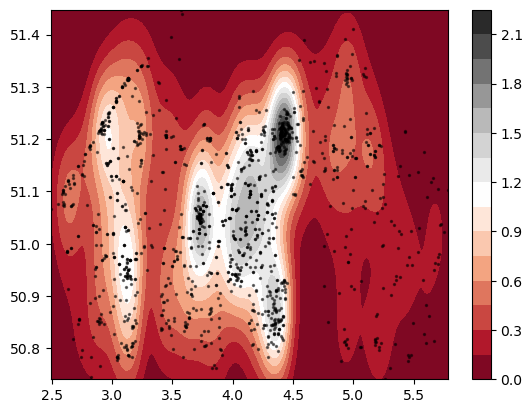

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import kde


data = np.array(coordinates)  # Convert list of arrays into a numpy array

x = np.linspace(data[:, 1].min(), data[:, 1].max(), 500) # switched
y = np.linspace(data[:, 0].min(), data[:, 0].max(), 500) # switched
X, Y = np.meshgrid(x, y)
xy = np.vstack([Y.ravel(), X.ravel()]).T # switched

# Fit the KDE and evaluate on the grid
kde = KernelDensity(kernel='gaussian', bandwidth=0.08)
kde.fit(data)
Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# Plot the density distribution
contourf = plt.contourf(X, Y, Z, levels=20, cmap='RdGy')  # filled contours
plt.colorbar(contourf)  # Add color bar

# Plot the points on top of the density plot
plt.scatter(data[:, 1], data[:, 0], color='black', edgecolor='black', alpha=0.5, s=2) # switched, size reduced, color changed to blue

plt.show()

Define objetive function.

In [6]:
from scipy import optimize

# your data
data = np.array(coordinates)

# Fit the KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.05)
kde.fit(data)

# Define a function to calculate the negative KDE, since we'll be minimizing
def neg_kde(x):
    return -np.exp(kde.score_samples(x.reshape(1, -1)))

Now, we will attempt to find the maximal position in our density distribution via the SMA.

In [11]:
sma = BaseSMA(obj_func=neg_kde, lb=[49, 2.2], ub=[52.5, 6], problem_size=2, verbose=False)
g_best, fitness, loss, optimal_positions = sma.train()
g_best

Convergence achieved at epoch 163. Training stopped.


array([51.21214837,  4.43178365])

The SMA shows us that the most frituur-dense place should be around Antwerpen-stad. This is in line with the visual contour plot of our obtained density distribtuion.

Convergence achieved at epoch 57. Training stopped.


MovieWriter imagemagick unavailable; using Pillow instead.


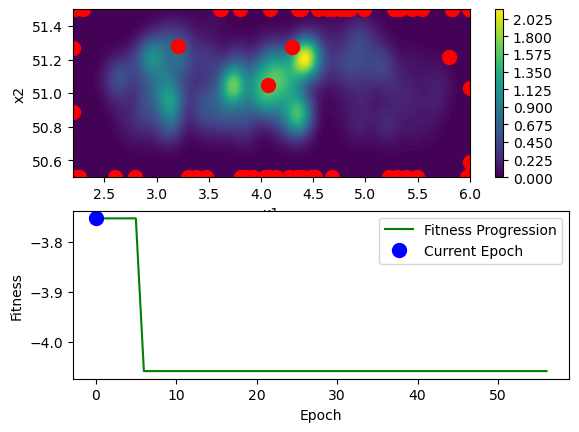

In [8]:
sma = BaseSMA(obj_func=neg_kde, lb=[50.5, 2.2], ub=[51.5, 6], problem_size=2, verbose=False)
g_best, fitness, loss, optimal_positions = sma.train()
g_best

x = np.linspace(2.2, 6, 500) # switched
y = np.linspace(50.5, 51.5, 500) # switched
X, Y = np.meshgrid(x, y)
xy = np.vstack([Y.ravel(), X.ravel()]).T # switched

# Fit the KDE and evaluate on the grid
kde = KernelDensity(kernel='gaussian', bandwidth=0.08)
kde.fit(data)
Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

fig, (ax1, ax2) = plt.subplots(2, 1)

contourf = ax1.contourf(X, Y, Z, levels=100, cmap='viridis')
fig.colorbar(contourf, ax=ax1)

# Create empty lists for markers
markers = []

# Set labels for ax1
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

# For the second plot, the setup is the same as the 1D case
x_min, x_max = 0, len(loss)
y_min, y_max = min(loss), max(loss)

u = np.arange(len(loss))
line2, = ax2.plot(u, loss, 'g-', label='Fitness Progression')
marker2, = ax2.plot([], [], 'bo', markersize=10, label='Current Epoch')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Fitness')

# Update function for animation
def update(frame):
    # Remove old markers from ax1
    for marker in markers:
        marker.remove()
    markers.clear()

    # Add new markers to ax1
    for position in optimal_positions[frame]:
        marker, = ax1.plot(position[1], position[0], 'ro', markersize=10)
        markers.append(marker)
    
    # Update marker2 position in ax2
    marker2.set_data(frame, loss[frame])
    
    return markers, marker2

# Create the animation
animation = FuncAnimation(fig, update, frames=len(optimal_positions), interval=200)

# Save the animation as a GIF
animation.save("fig/frituurDENSITY.gif", writer='imagemagick')


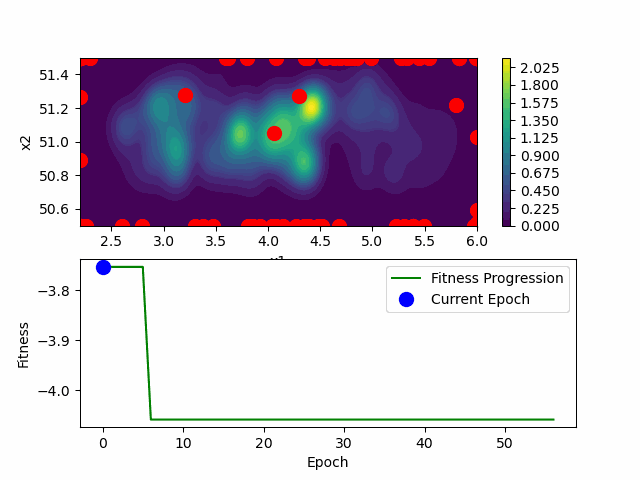

In [9]:
Image(filename='fig/frituurDENSITY.gif')